In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
BATCH=200
path = r'C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\img'

In [114]:
import os
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
import imageio


class Imaged_data_set(Dataset):
    def __init__(self, folder, transform = None, size = 1, start = True, filtered = None):
        self.folder = Path(folder)
        self.names = os.listdir(self.folder)[:-1]
        
        
        if start:
            self.names = self.names[:int(size*(len(self.names)))]
        else: 
            self.names = self.names[int((1-size)*(len(self.names))): ]
        self.names.sort(key= lambda x: int(x.split("_")[0]))
        self.transform = transform
        self.images = []
        self.target = []
        for idx in range(len(self.names)):
            self.images.append(np.array(imageio.imread(str(self.folder/self.names[idx]))))
            self.target.append(float(self.names[idx].split("_")[1]))
        self.images = np.array(self.images)
        self.target = np.array(self.target)
        
        if filtered:
            self.images = self.images[filtered(self.target)]
            self.target = self.target[filtered(self.target)]
        
        
    def __getitem__(self, idx):
        
        np_img = self.images[idx]
        y_true = self.target[idx]
        if self.transform:
            np_img = self.transform(np_img)
            y_true = torch.tensor(y_true, dtype=torch.float)
            y_true = y_true.view(-1,)


        
        return np_img, y_true
    def __len__(self):
        return  len(self.target)
    def print_target_statistic(self):
        
        print(f"MEAN = {self.target.mean()} \t MSE = {self.target.std()**2} \t SIGMA = {self.target.std()}")

In [115]:
def condition(a):
    return a > 0.113

In [116]:
train_loader_1 = Imaged_data_set(path, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]), size = 1, start = True, filtered = condition)
test_loader_1 = Imaged_data_set(path, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]), size = 0.5, start = False, filtered = condition)

In [117]:
train_loader_1.print_target_statistic()

MEAN = 0.11853999059336091 	 MSE = 1.0956723746544807e-05 	 SIGMA = 0.0033100942201914445


In [118]:
train_loader = torch.utils.data.DataLoader(
        train_loader_1,
     batch_size=BATCH, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        test_loader_1,
batch_size=BATCH, shuffle=True)

In [119]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #self.conv3 = nn.Conv2d(50, 60, 5, 1)

        self.fc1 = nn.Linear(14*19*50, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = F.max_pool2d(x, 3, 3)
        #x = F.relu(self.conv3(x))
        #print(x.shape)

        #x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 14*19*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t mse: {}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), target.std()**2))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.7f}\n'.format(
        test_loss))

In [120]:
model = Net()
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 10):
    train( model, device, train_loader, optimizer, epoch)
    test( model, device, test_loader)


Train Epoch: 1 [0/1624 (0%)]	Loss: 0.011324	 mse: 1.2090266864106525e-05

Test set: Average loss: 0.0068163

Train Epoch: 2 [0/1624 (0%)]	Loss: 0.006809	 mse: 1.0688023394322954e-05

Test set: Average loss: 0.0025722

Train Epoch: 3 [0/1624 (0%)]	Loss: 0.002559	 mse: 1.09845041151857e-05

Test set: Average loss: 0.0014086

Train Epoch: 4 [0/1624 (0%)]	Loss: 0.001397	 mse: 1.1147831173730083e-05

Test set: Average loss: 0.0011094

Train Epoch: 5 [0/1624 (0%)]	Loss: 0.001153	 mse: 1.0000410838983953e-05

Test set: Average loss: 0.0006922



In [51]:
for x,y in train_loader:
    break

In [55]:
pred = model(x)

In [56]:
pred_np = np.array(pred.reshape(-1).detach())
y_np =  np.array(y)

In [57]:
import matplotlib.pyplot as plt


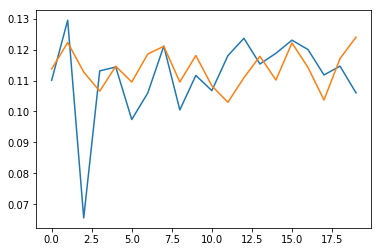

In [58]:
plt.plot(pred_np[:20])
plt.plot(y_np[:20])
plt.show()

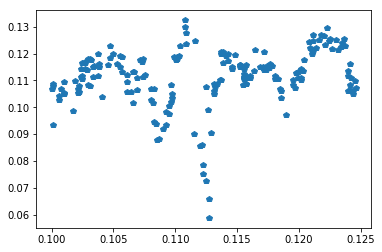

In [59]:

plt.plot(y_np, pred_np, 'p')

In [110]:
valid_data = Imaged_data_set(path, filtered = condition)

In [111]:
intensity = np.zeros(len(valid_data))
phases = np.zeros(len(valid_data))

In [112]:
for i in range(len(valid_data)):
    intensity[i] = valid_data[i][0].mean()
    phases[i] = valid_data[i][1] 

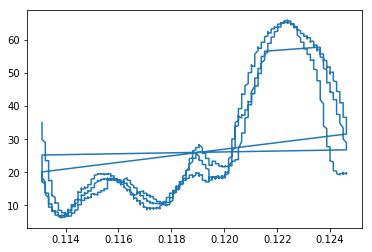

In [113]:
plt.plot(phases, intensity)

In [84]:
path1 = Path(r'C:\Users\ЛФКИТ-3\Documents\quantTechLab\data')

In [85]:
save_to=path1/"inten.csv"
save_phases_to=path1/"pases.csv"

In [87]:

data = intensity
np.savetxt(save_to,data,delimiter=',',fmt='%10.5f')
print ("saved to %s"%save_to)


data = phases
np.savetxt(save_phases_to,data,delimiter=',',fmt='%10.5f')
print ("saved to %s"%save_phases_to)

saved to C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\inten.csv
saved to C:\Users\ЛФКИТ-3\Documents\quantTechLab\data\pases.csv
